In [1]:
import psycopg2

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import matplotlib.cm as cm

from pprint import pprint
from math import floor

try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="tempdb", password="coap")
  con.set_session(readonly=True, autocommit=True)

In [2]:
%%time 

exp_data_sql = """
SELECT
	ex.*,
	d.dnid,
	n.*
FROM
	experiment ex
	JOIN deployed_node d ON d.exp_id = ex.exp_id
	JOIN node n ON d.node_id = n.node_id
GROUP BY
	ex.exp_id,
	n.node_id,
	d.dnid
ORDER BY
	ex.attacker_rate,
	ex.num_proxy_connections
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
print()
lay_of_the_land

cloud_proxy_and_500mbpsattacker_withattacker
cloud_proxy_and_500mbpsattacker_withattacker_httpson
cloud_proxy_and_500mbpsattacker_withattacker_dtlson_httpson
cloud_proxy_and_500mbpsattacker_withattacker_dtlson

CPU times: user 12.6 ms, sys: 2.2 ms, total: 14.8 ms
Wall time: 23 ms


/home/ubuntu/.local/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,exp_id,attacker_rate,server_connections,max_keep_alive_requests,num_clients,num_trials,origin_server_duration,attacker_duration,receiver_duration,proxy_duration,...,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker,dnid,node_id,node_name,hardware_type,operating_system
0,cloud_proxy_and_500mbpsattacker_withattacker,500mbps,256,0,1,3,120,20,120,120,...,1,True,False,False,True,19,4,proxy,microcloud,ubuntu1804-std
1,cloud_proxy_and_500mbpsattacker_withattacker,500mbps,256,0,1,3,120,20,120,120,...,1,True,False,False,True,17,2,client1,microcloud,ubuntu1804-std
2,cloud_proxy_and_500mbpsattacker_withattacker_h...,500mbps,256,0,1,3,120,20,120,120,...,1,True,True,True,True,15,5,receiver,microcloud,ubuntu1804-std
3,cloud_proxy_and_500mbpsattacker_withattacker_h...,500mbps,256,0,1,3,120,20,120,120,...,1,True,True,True,True,14,4,proxy,microcloud,ubuntu1804-std
4,cloud_proxy_and_500mbpsattacker_withattacker,500mbps,256,0,1,3,120,20,120,120,...,1,True,False,False,True,20,5,receiver,microcloud,ubuntu1804-std
5,cloud_proxy_and_500mbpsattacker_withattacker_d...,500mbps,256,0,1,3,120,20,120,120,...,1,True,True,True,True,9,4,proxy,microcloud,ubuntu1804-std
6,cloud_proxy_and_500mbpsattacker_withattacker_d...,500mbps,256,0,1,3,120,20,120,120,...,1,True,True,True,True,8,8,originserver,microcloud,ubuntu1804-std
7,cloud_proxy_and_500mbpsattacker_withattacker_d...,500mbps,256,0,1,3,120,20,120,120,...,1,True,True,False,True,1,1,attacker,microcloud,ubuntu1804-std
8,cloud_proxy_and_500mbpsattacker_withattacker_d...,500mbps,256,0,1,3,120,20,120,120,...,1,True,True,False,True,4,4,proxy,microcloud,ubuntu1804-std
9,cloud_proxy_and_500mbpsattacker_withattacker_d...,500mbps,256,0,1,3,120,20,120,120,...,1,True,True,True,True,7,7,client1,microcloud,ubuntu1804-std


In [3]:
%%time 

exp_id = "cloud_proxy_and_500mbpsattacker_withattacker"

df = lay_of_the_land
df = df[(df["exp_id"] == exp_id)]

exp_config = df.head(1).to_dict(orient="records")[0]
run_proxy_with_dtls = exp_config["run_proxy_with_dtls"]

records = df[["node_name", "dnid", "node_id"]].to_records(index=False)

node_map_node_id = dict()
node_map_dnid = dict()
client_node_ids = set()
client_dnids = set()
proxy_node_id = None
proxy_dnid = None
attacker_node_id = None
attacker_dnid = None
attacker_message_receiver_node_id = None
attacker_message_receiver_dnid = None
receiver_node_id = None
receiver_dnid = None

for node_name, dnid, node_id in records:
    node_map_node_id[node_name] = node_id
    node_map_dnid[node_name] = dnid
    if node_name.startswith("client"):
        client_node_ids.add(node_id)
        client_dnids.add(dnid)
    elif node_name == 'proxy':
        proxy_node_id = node_id
        proxy_dnid = dnid
    elif node_name == 'attacker':
        attacker_node_id = node_id
        attacker_dnid = dnid
    elif node_name == 'receiver':
        receiver_node_id = node_id
        receiver_dnid = dnid
    
dnid_map_node = {d:n for n,d in node_map_dnid.items()}
experiment_dnids = set(dnid_map_node.keys())

if not run_proxy_with_dtls:
  # The attacker regularly exploits IP address spoofing
  # to "purify" its attacking process by forcing all traffic
  # that it sent to go to the receiver
  attacker_message_receiver_node_id = receiver_node_id
  attacker_message_receiver_dnid = receiver_dnid
else:
  # Running with DTLS means the attacker receives
  # all the traffic it sent out, because there is
  # no spoofing with DTLS
  attacker_message_receiver_node_id = attacker_node_id
  attacker_message_receiver_dnid = attacker_dnid
    
print(f"{node_map_node_id=}")
print(f"{node_map_dnid=}")
print(f"{dnid_map_node=}")
print(f"{experiment_dnids=}")
print()
print(f"{client_node_ids=}")
print(f"{client_dnids=}")
print()
print(f"{attacker_message_receiver_node_id=}")
print(f"{attacker_message_receiver_dnid=}")
print()

exp_config

node_map_node_id={'proxy': 4, 'client1': 2, 'receiver': 5, 'attacker': 1, 'originserver': 3}
node_map_dnid={'proxy': 19, 'client1': 17, 'receiver': 20, 'attacker': 16, 'originserver': 18}
dnid_map_node={19: 'proxy', 17: 'client1', 20: 'receiver', 16: 'attacker', 18: 'originserver'}
experiment_dnids={16, 17, 18, 19, 20}

client_node_ids={2}
client_dnids={17}

attacker_message_receiver_node_id=5
attacker_message_receiver_dnid=20

CPU times: user 20.5 ms, sys: 4.23 ms, total: 24.7 ms
Wall time: 23.1 ms


{'exp_id': 'cloud_proxy_and_500mbpsattacker_withattacker',
 'attacker_rate': '500mbps',
 'server_connections': 256,
 'max_keep_alive_requests': 0,
 'num_clients': 1,
 'num_trials': 3,
 'origin_server_duration': 120,
 'attacker_duration': 20,
 'receiver_duration': 120,
 'proxy_duration': 120,
 'client_duration': 100,
 'attacker_start_lag_duration': 20,
 'topology_name': 'cloud_proxy_cloud_attacker',
 'num_proxy_connections': 50,
 'request_timeout': '5',
 'max_retries': 2,
 'keep_alive_duration': '5',
 'request_retry_interval': '1',
 'reuse_connections': True,
 'run_proxy_with_dtls': False,
 'run_proxy_with_https': False,
 'run_attacker': True,
 'dnid': 19,
 'node_id': 4,
 'node_name': 'proxy',
 'hardware_type': 'microcloud',
 'operating_system': 'ubuntu1804-std'}

In [4]:
%%time

summary_sql = f"""
SELECT 
	'{exp_id}' AS exp_id,
	e.observer_id,
	e.trial,
	COUNT (e.message_marker) AS total_messages,
	MIN(e.observe_timestamp) min_timestamp_sec,
	MAX(e.observe_timestamp) max_timestamp_sec,
	MAX(e.observe_timestamp) - MIN(e.observe_timestamp) active_time_sec,
	(SELECT ex.run_proxy_with_dtls FROM experiment ex WHERE ex.exp_id = '{exp_id}') AS run_proxy_with_dtls
FROM  
	event e
WHERE 
	e.observer_id IN ({','.join(map(str, experiment_dnids))})
GROUP BY
	e.observer_id, e.trial
"""

sdf = pd.read_sql_query(summary_sql, con)
sdf.observer_id.replace(dnid_map_node, inplace=True)
sdf

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


CPU times: user 11.5 ms, sys: 1.55 ms, total: 13.1 ms
Wall time: 830 ms


,exp_id,observer_id,trial,total_messages,min_timestamp_sec,max_timestamp_sec,active_time_sec,run_proxy_with_dtls
0,cloud_proxy_and_500mbpsattacker_withattacker,attacker,1,506725,19.041529,38.879207,19.837678,False
1,cloud_proxy_and_500mbpsattacker_withattacker,attacker,2,501440,20.503070,40.411050,19.907980,False
2,cloud_proxy_and_500mbpsattacker_withattacker,attacker,3,509672,20.502774,40.418376,19.915602,False
3,cloud_proxy_and_500mbpsattacker_withattacker,client1,1,2700,0.000000,97.301939,97.301939,False
4,cloud_proxy_and_500mbpsattacker_withattacker,client1,2,2753,0.044398,98.745165,98.700767,False
5,cloud_proxy_and_500mbpsattacker_withattacker,client1,3,2749,0.055464,98.707707,98.652243,False
6,cloud_proxy_and_500mbpsattacker_withattacker,originserver,1,171018,0.174520,98.082678,97.908158,False
7,cloud_proxy_and_500mbpsattacker_withattacker,originserver,2,170494,0.155234,99.576683,99.421449,False
8,cloud_proxy_and_500mbpsattacker_withattacker,originserver,3,167322,0.173893,99.594493,99.420600,False
9,cloud_proxy_and_500mbpsattacker_withattacker,proxy,1,1075404,0.006598,98.018670,98.012072,False


/home/ubuntu/.local/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


<IPython.core.display.Javascript object>


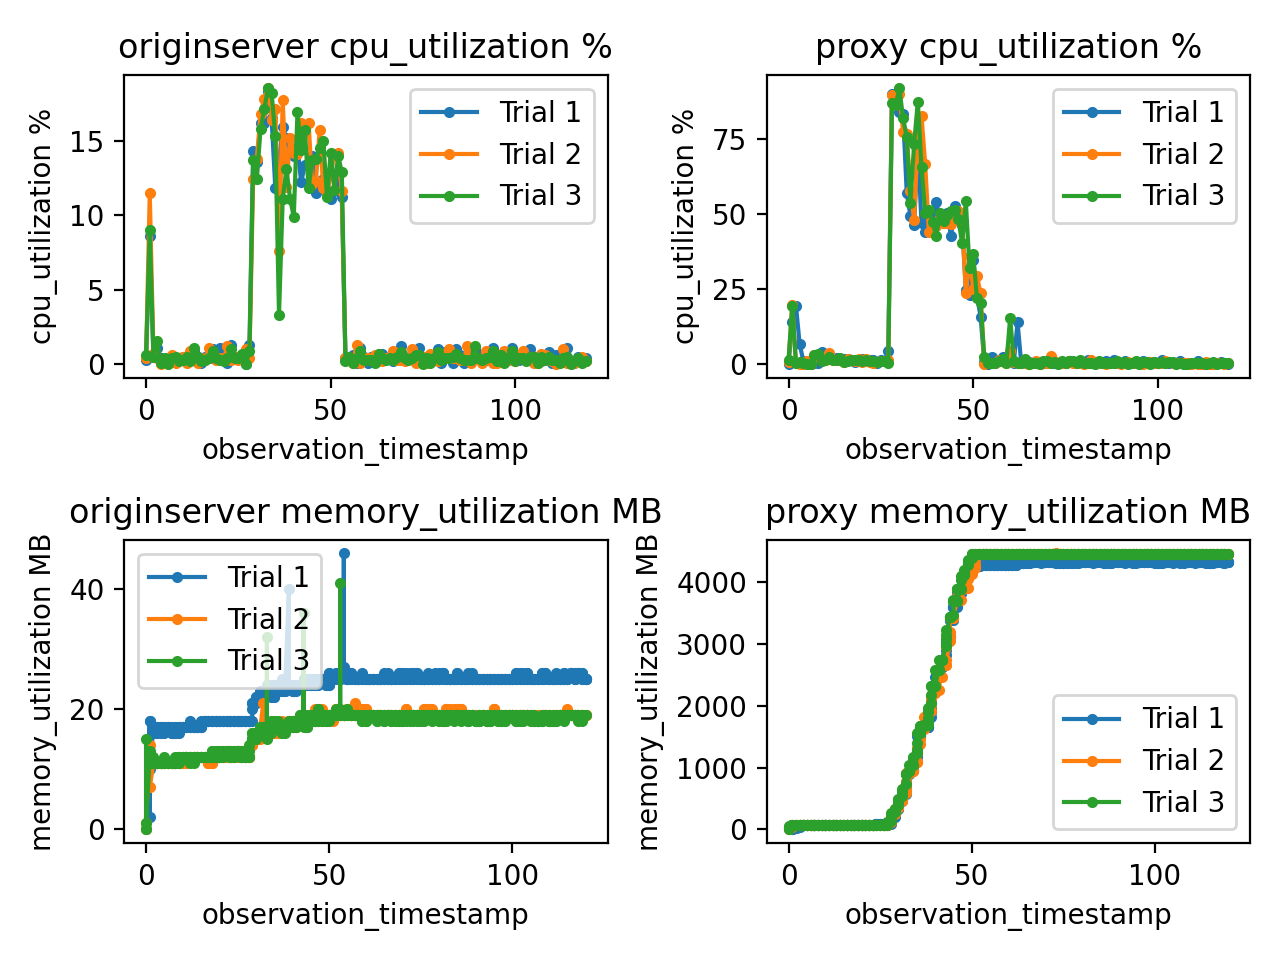

CPU times: user 606 ms, sys: 242 ms, total: 849 ms
Wall time: 449 ms


,observer_id,trial,observation_timestamp,metric_type,metric_value
0,originserver,1,0,cpu_utilization,0.7
1,originserver,1,0,memory_utilization,218.0
2,originserver,1,1,cpu_utilization,9.0
3,originserver,1,1,memory_utilization,236.0
4,originserver,1,1,memory_utilization,236.0
...,...,...,...,...,...
3815,proxy,3,119,memory_utilization,4696.0
3816,proxy,3,119,memory_utilization,4696.0
3817,proxy,3,119,memory_utilization,4695.0
3818,proxy,3,120,memory_utilization,4696.0


In [5]:
%%time

%matplotlib notebook

# Plot the node metrics for each device

metrics_sql = f"""
SELECT nm.*
FROM node_metric nm
WHERE nm.observer_id IN ({','.join(map(str, dnid_map_node.keys()))})
ORDER BY nm.observer_id, nm.trial, nm.observation_timestamp, nm.metric_type
"""

metrics_df = pd.read_sql_query(metrics_sql, con)

metrics_df

# Replace dnids with human-readable node names
metrics_df.observer_id.replace(dnid_map_node, inplace=True)

metric_types = metrics_df.metric_type.unique()
node_names = metrics_df.observer_id.unique()
trials = metrics_df.trial.unique()

metric_type_map_extension = {
    "cpu_utilization": "%",
    "memory_utilization": "MB",
}

fig, axs = plt.subplots(len(node_names), len(metric_types))
for i, mt in enumerate(metric_types):
    for j, node_name in enumerate(node_names):
        for t in trials:
            # Filter each metric type observer node into its own tile, further filter by trial
            ax = axs[i, j]
            _df = metrics_df[(metrics_df["metric_type"] == mt) 
                             & (metrics_df["observer_id"] == node_name)
                             & (metrics_df["trial"] == t)]
            
            # Normalize the timestamp and metric value of the experiment
            _df["observation_timestamp"] -= min(_df["observation_timestamp"])
            _df["metric_value"] -= min(_df["metric_value"])
            
            _df.plot(kind="line", x="observation_timestamp", y="metric_value", marker=".", ax=ax, label=f"Trial {t}")

            ylabel = mt + " " + metric_type_map_extension[mt]
            ax.set_ylabel(ylabel)
            ax.set_title(node_name + " " + ylabel)

fig.tight_layout()
plt.show()

metrics_df

In [6]:
%%time

client_messages_sql = f"""
SELECT
	dn.exp_id,
	client_sends.trial,
	client_sends.observer_id,
	client_sends.message_marker,
	MIN(client_sends.observe_timestamp) AS send_time_sec,
	MIN(client_recvs.observe_timestamp) AS recv_time_sec,
	MIN(client_sends.observe_timestamp) AS first_send_time_sec,
	MAX(client_sends.observe_timestamp) AS last_send_time_sec,
	MIN(client_recvs.observe_timestamp) AS first_recv_time_sec,
	MAX(client_recvs.observe_timestamp) AS last_recv_time_sec,
	1e3 * (MIN(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS rtt_ms_first_transmission,
	1e3 * (MIN(client_recvs.observe_timestamp) - MAX(client_sends.observe_timestamp)) AS rtt_ms_last_transmission,
	COUNT(client_sends.*) AS num_send_observations,
	COUNT(client_recvs.*) AS num_recv_observations,
	SUM(CASE WHEN cm_send.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM
	event client_sends
		JOIN message m_sends ON m_sends.message_id = client_sends.message_id
			JOIN coap_message cm_send ON cm_send.cmci = m_sends.coap_message
	JOIN event client_recvs
		ON client_recvs.trial = client_sends.trial
		AND client_recvs.observer_id = client_sends.observer_id
		AND client_recvs.message_marker = client_sends.message_marker
		JOIN message m_recvs ON m_recvs.message_id = client_recvs.message_id
	JOIN deployed_node dn 
		ON (dn.dnid = client_sends.observer_id AND dn.dnid = client_recvs.observer_id)
WHERE
	client_sends.observer_id IN ({','.join(map(str, client_dnids))})     -- clients senders are observers (observer ID)
		AND m_sends.src_id != {proxy_node_id}                            -- proxy is not the sender (node ID)
	AND client_recvs.observer_id IN ({','.join(map(str, client_dnids))}) -- clients receivers are observers (observer ID)
		AND m_recvs.src_id = {proxy_node_id}                             -- proxy is the sender (node ID)
GROUP BY
	dn.exp_id, client_sends.trial, client_sends.observer_id, client_sends.message_marker
ORDER BY
	dn.exp_id, client_sends.trial, client_sends.observer_id, client_sends.message_marker
"""

rtts_df = pd.read_sql_query(client_messages_sql, con)
rtts_df.observer_id.replace(dnid_map_node, inplace=True)

# Compute RTT stats and merge into the df
stats_df = (
  rtts_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .agg(
    num_messages=("message_marker", pd.Series.nunique),
    global_first_send_time_sec=("send_time_sec", "min"),
    global_last_recv_time_sec=("recv_time_sec", "max"),
  )
  .reset_index()
)
stats_df["average_rps"] = stats_df["num_messages"] / (stats_df["global_last_recv_time_sec"] - stats_df["global_first_send_time_sec"])
rtts_df = rtts_df.merge(stats_df, on=["exp_id", "trial", "observer_id"])

rtts_df

CPU times: user 78.5 ms, sys: 10.4 ms, total: 88.9 ms
Wall time: 129 ms


/home/ubuntu/.local/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,exp_id,trial,observer_id,message_marker,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,last_recv_time_sec,rtt_ms_first_transmission,rtt_ms_last_transmission,num_send_observations,num_recv_observations,num_retransmissions,num_messages,global_first_send_time_sec,global_last_recv_time_sec,average_rps
0,cloud_proxy_and_500mbpsattacker_withattacker,1,client1,1,0.000000,0.207288,0.000000,0.000000,0.207288,0.207288,207.288027,207.288027,1,1,0,1347,0.000000,97.301259,13.843603
1,cloud_proxy_and_500mbpsattacker_withattacker,1,client1,2,0.231558,0.288233,0.231558,0.231558,0.288233,0.288233,56.674957,56.674957,1,1,0,1347,0.000000,97.301259,13.843603
2,cloud_proxy_and_500mbpsattacker_withattacker,1,client1,3,0.290401,0.346598,0.290401,0.290401,0.346598,0.346598,56.197166,56.197166,1,1,0,1347,0.000000,97.301259,13.843603
3,cloud_proxy_and_500mbpsattacker_withattacker,1,client1,4,0.348780,0.404318,0.348780,0.348780,0.404318,0.404318,55.537939,55.537939,1,1,0,1347,0.000000,97.301259,13.843603
4,cloud_proxy_and_500mbpsattacker_withattacker,1,client1,5,0.406691,0.462530,0.406691,0.406691,0.462530,0.462530,55.839062,55.839062,1,1,0,1347,0.000000,97.301259,13.843603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4088,cloud_proxy_and_500mbpsattacker_withattacker,3,client1,511040,98.441597,98.494085,98.441597,98.441597,98.494085,98.494085,52.488089,52.488089,1,1,0,1372,0.055464,98.707052,13.907531
4089,cloud_proxy_and_500mbpsattacker_withattacker,3,client1,511041,98.494717,98.547223,98.494717,98.494717,98.547223,98.547223,52.505970,52.505970,1,1,0,1372,0.055464,98.707052,13.907531
4090,cloud_proxy_and_500mbpsattacker_withattacker,3,client1,511042,98.547876,98.600488,98.547876,98.547876,98.600488,98.600488,52.611828,52.611828,1,1,0,1372,0.055464,98.707052,13.907531
4091,cloud_proxy_and_500mbpsattacker_withattacker,3,client1,511043,98.601133,98.653692,98.601133,98.601133,98.653692,98.653692,52.558899,52.558899,1,1,0,1372,0.055464,98.707052,13.907531


<IPython.core.display.Javascript object>


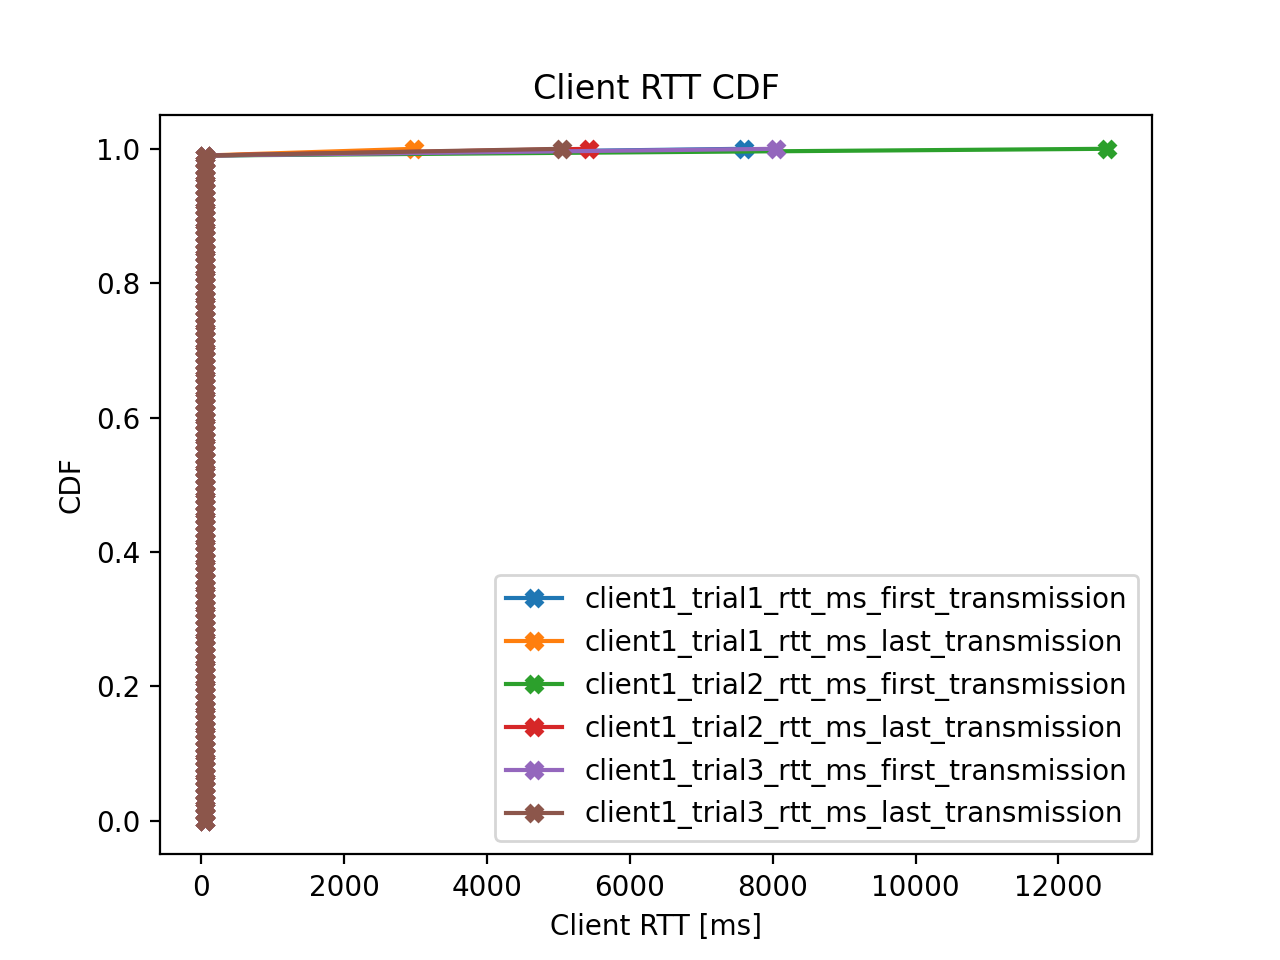

,percentile,trial,message_marker,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,last_recv_time_sec,rtt_ms_first_transmission,rtt_ms_last_transmission,num_send_observations,num_recv_observations,num_retransmissions,num_messages,global_first_send_time_sec,global_last_recv_time_sec,average_rps
count,101.000000,101.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.0,101.000000,101.000000,101.000000
mean,0.500000,3.0,369189.978614,55.174476,55.242858,55.174476,55.179099,55.242858,55.242858,132.029082,102.440983,1.009901,1.009901,0.009901,1372.0,0.055464,98.707052,13.907531
std,0.293002,0.0,229391.875042,30.973170,30.955029,30.973170,30.968048,30.955029,30.955029,795.144404,497.787841,0.099504,0.099504,0.099504,0.0,0.000000,0.000000,0.000000
min,0.000000,3.0,1.000000,0.055464,0.212395,0.055464,0.055464,0.212395,0.212395,51.940918,51.940918,1.000000,1.000000,0.000000,1372.0,0.055464,98.707052,13.907531
25%,0.250000,3.0,343.750000,19.076160,19.129480,19.076160,19.076160,19.129480,19.129480,52.552760,52.552760,1.000000,1.000000,0.000000,1372.0,0.055464,98.707052,13.907531
50%,0.500000,3.0,510358.500000,62.113086,62.165684,62.113086,62.113086,62.165684,62.165684,52.616000,52.616000,1.000000,1.000000,0.000000,1372.0,0.055464,98.707052,13.907531
75%,0.750000,3.0,510701.250000,80.400418,80.452978,80.400418,80.400418,80.452978,80.452978,53.404093,53.404093,1.000000,1.000000,0.000000,1372.0,0.055464,98.707052,13.907531
max,1.000000,3.0,511044.000000,98.654353,98.707052,98.654353,98.654353,98.707052,98.707052,8044.008970,5055.610895,2.000000,2.000000,1.000000,1372.0,0.055464,98.707052,13.907531


In [7]:
plot_args = {
    "kind"  : "line",
    "y"     : "percentile",
    "marker": "X",
}

trials = rtts_df["trial"].unique()
clients = rtts_df["observer_id"].unique()
rtts = ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]

ax = None
for t in trials:
  for c in clients:
    cdfdf = rtts_df[(rtts_df["trial"] == t) & (rtts_df["observer_id"] == c)]
    cdfdf = cdfdf.quantile(q=tuple(_q/100 for _q in range(0, 101, 1))).reset_index().rename(columns={"index":"percentile"})
    for rtt in rtts:
        label = f"{c}_trial{t}_{rtt}"
        ax = cdfdf.plot(x=rtt, label=label, ax = ax, **plot_args)

ax.set_ylabel("CDF")
ax.set_xlabel("Client RTT [ms]")
ax.set_title("Client RTT CDF")
plt.show()

cdfdf.describe()

In [28]:
cdfdf[(cdfdf["num_send_observations"] > 1) | (cdfdf["num_recv_observations"] > 1)]

,percentile,trial,message_marker,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,last_recv_time_sec,rtt_ms_first_transmission,rtt_ms_last_transmission,num_send_observations,num_recv_observations,num_retransmissions,num_messages,global_first_send_time_sec,global_last_recv_time_sec,average_rps
100,1.0,3.0,511044.0,98.654353,98.707052,98.654353,98.654353,98.707052,98.707052,8044.00897,5055.610895,2.0,2.0,1.0,1372.0,0.055464,98.707052,13.907531


<IPython.core.display.Javascript object>


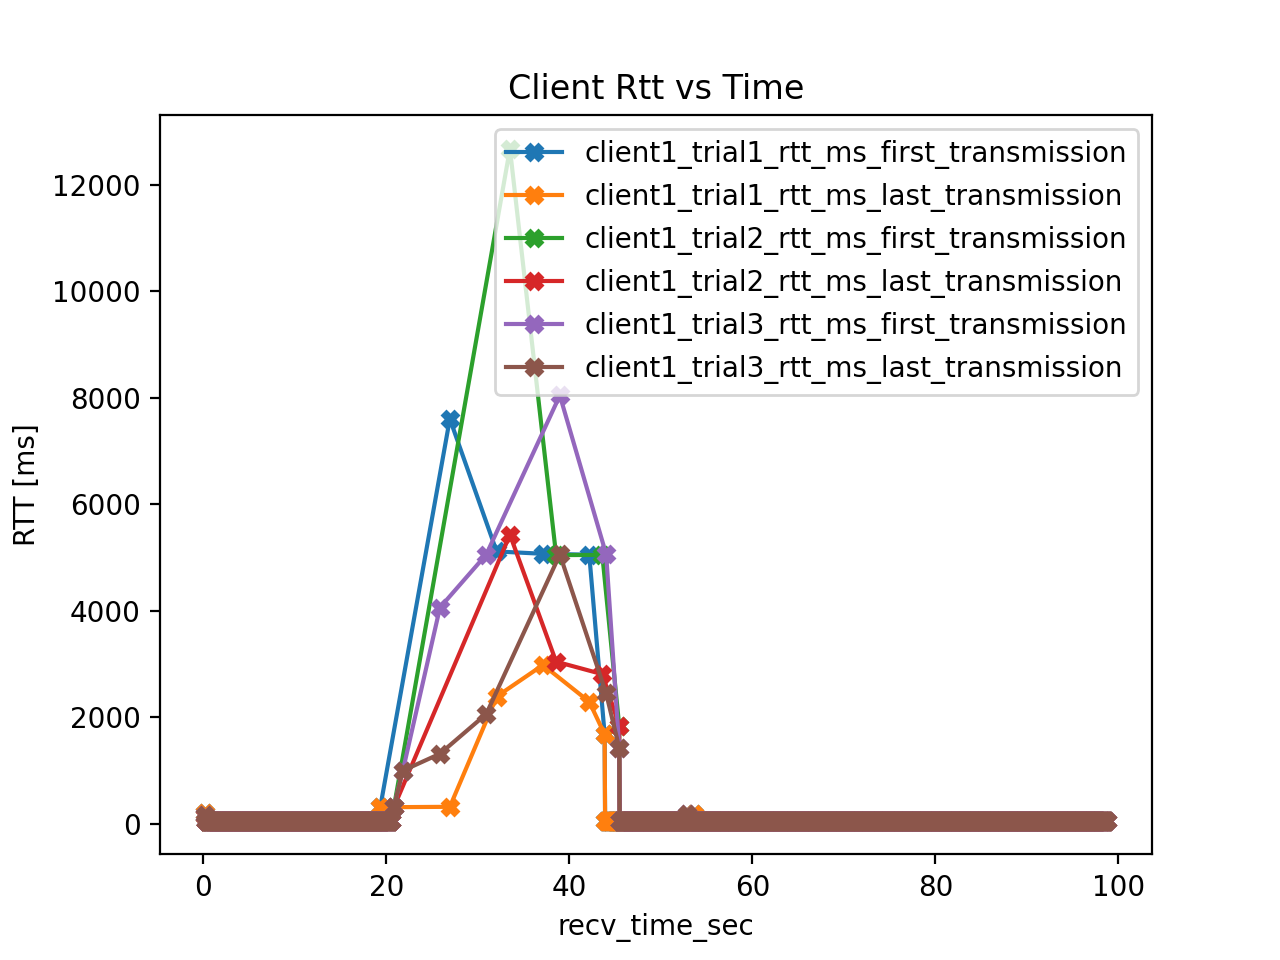

In [8]:
ignore_clients = {}
ignore_trials = {}

plot_args = {
    "kind"  : "line",
    "x"     : "recv_time_sec",
    "marker": "X",
}

# `trials`, `clients`, and `rtts` derived from above

ax = None
for t in trials:
    if t in ignore_trials:
        continue
        
    for c in clients:
        if c in ignore_clients:
            continue
            
        client_trial_df = rtts_df[(rtts_df["trial"] == t) & (rtts_df["observer_id"] == c)]
        
        for rtt in rtts:
          label = f"{c}_trial{t}_{rtt}"
          ax = client_trial_df.plot(label=label, y=rtt, **plot_args, ax=ax)

ax.set_title("Client Rtt vs Time")
ax.set_ylabel("RTT [ms]")
plt.show()

<IPython.core.display.Javascript object>


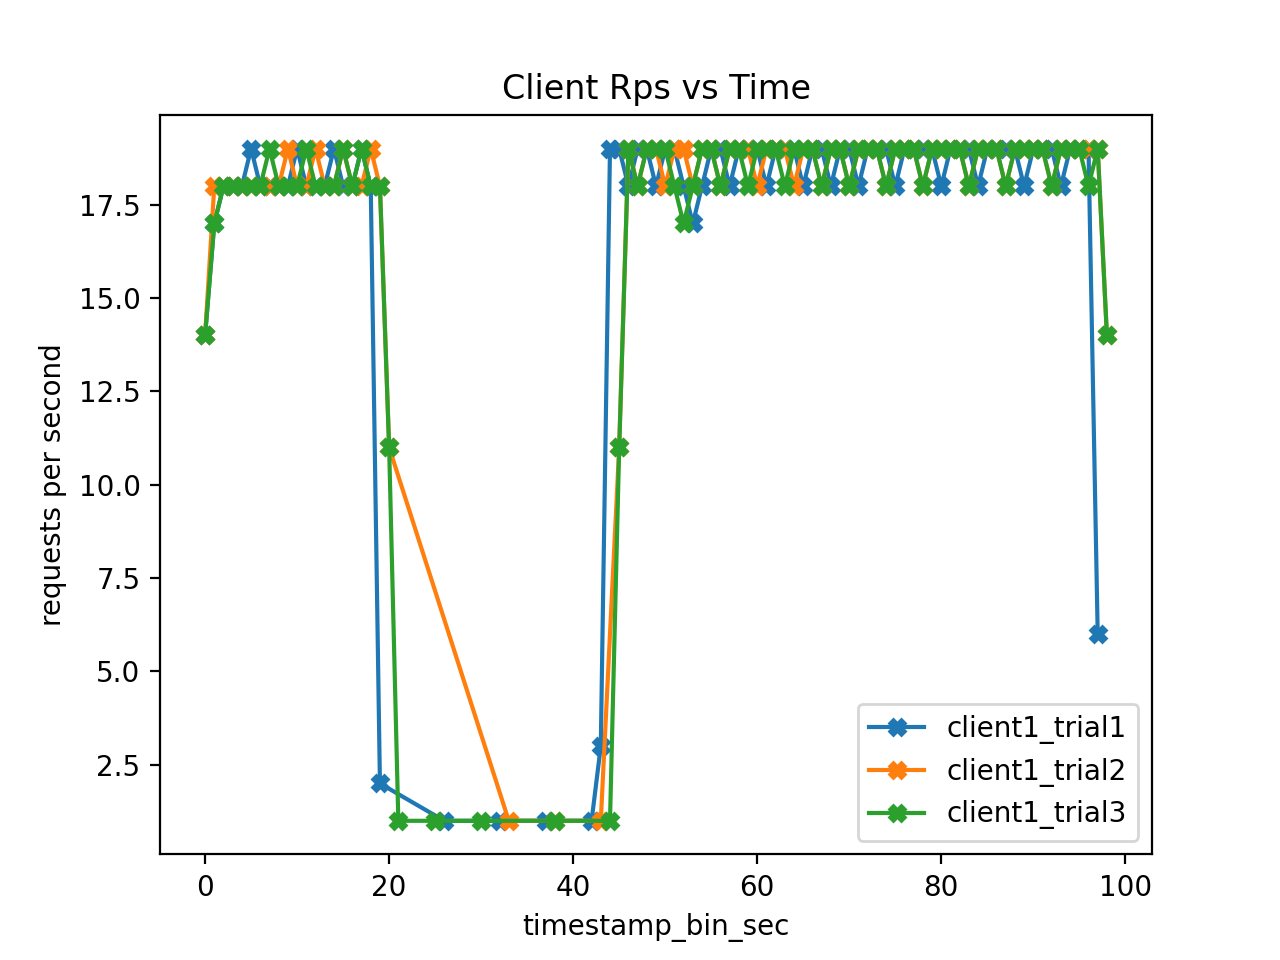

,timestamp_bin_sec,observer_id,packets_per_second
0,0.0,client1,14
1,1.0,client1,17
2,2.0,client1,18
3,3.0,client1,18
4,4.0,client1,18
...,...,...,...
75,94.0,client1,19
76,95.0,client1,19
77,96.0,client1,18
78,97.0,client1,19


In [9]:
ignore_clients = {}
ignore_trials = {}

plot_args = {
    "kind"  : "line",
    "x"     : "timestamp_bin_sec",
    "y"     : "packets_per_second",
    "marker": "X",
}

# `trials`, `clients`, and `rtts` derived from above

ax = None
for t in trials:
    if t in ignore_trials:
        continue
        
    trial_df = rtts_df[rtts_df["trial"] == t]
    trial_df["timestamp_bin_sec"] = np.floor(trial_df["recv_time_sec"])
    time_stats_df = trial_df.groupby(by=["timestamp_bin_sec", "observer_id"]).agg(\
                                             packets_per_second=("average_rps", "count")).reset_index()
    
    for c in clients:
        if c in ignore_clients:
            continue
            
        client_trial_df = time_stats_df[time_stats_df["observer_id"] == c]
        
        label = f"{c}_trial{t}"
        ax = client_trial_df.plot(label=label, ax=ax, **plot_args)

ax.set_title("Client Rps vs Time")
ax.set_ylabel("requests per second")
plt.show()

time_stats_df

<IPython.core.display.Javascript object>


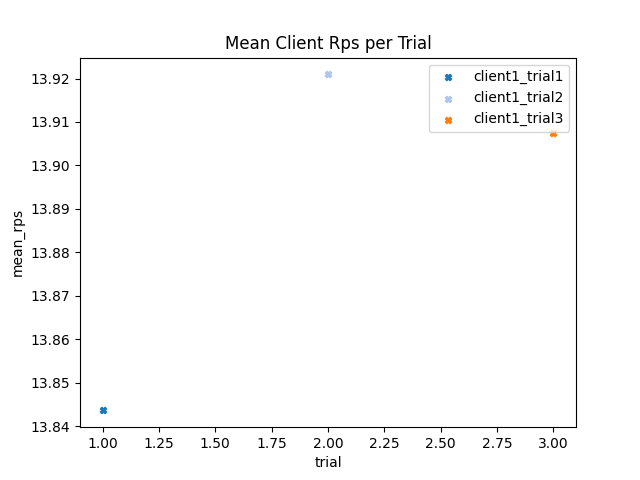

   trial   mean_rps
0      1  13.843603
1      2  13.920953
2      3  13.907531


,observer_id,trial,mean_rps
0,client1,1,13.843603
1,client1,2,13.920953
2,client1,3,13.907531


In [31]:
per_trial_stats_df = (
  rtts_df
  .groupby(by=["observer_id", "trial"])
  .agg(
    mean_rps=("average_rps", "mean")
  )
  .reset_index()
)

plot_args = {
    "kind"  : "scatter",
    "x"     : "trial",
    "y"     : "mean_rps",
    "marker": "X",
}

# `trials`, `clients`, and `rtts` derived from above

colors = iter([plt.cm.tab20(i) for i in range(20)])

ax = None
for t in trials:
    for c in clients:
        
        grouped_client_trial_df = per_trial_stats_df[(per_trial_stats_df["trial"] == t) & (per_trial_stats_df["observer_id"] == c)]
        
        label = "hi"
        label=f"{c}_trial{t}"
        ax = grouped_client_trial_df.plot(ax=ax, label=label, color=[next(colors)], **plot_args)
        
print(per_trial_stats_df.groupby(by=["trial"]).mean().reset_index()[["trial", "mean_rps"]])
       
ax.set_title("Mean Client Rps per Trial")
plt.show()

per_trial_stats_df

<IPython.core.display.Javascript object>


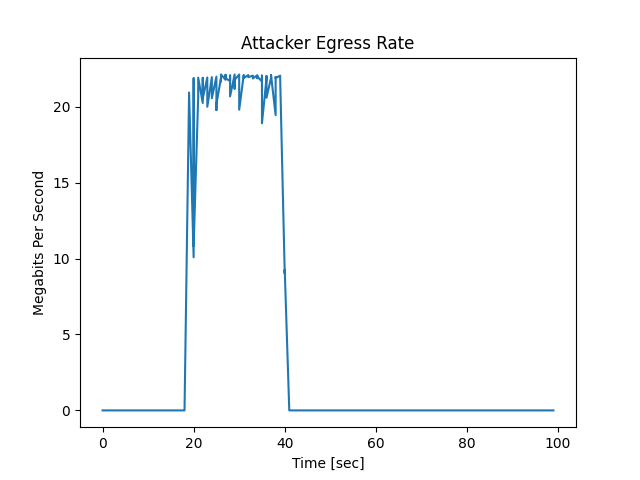

,trial,timestamp_bin,sum_bytes,megabytes_per_second,megabits_per_second
0,1,0.0,0.0,0.0,0.0
0,1,1.0,0.0,0.0,0.0
0,1,2.0,0.0,0.0,0.0
0,1,3.0,0.0,0.0,0.0
0,1,4.0,0.0,0.0,0.0
...,...,...,...,...,...
0,1,95.0,0.0,0.0,0.0
0,1,96.0,0.0,0.0,0.0
0,1,97.0,0.0,0.0,0.0
0,1,98.0,0.0,0.0,0.0


In [57]:
%%time

attack_rate_sql = f"""
SELECT
	'{exp_id}' AS exp_id,
	e.trial,
	{exp_config["client_duration"]} AS expected_client_duration,
	e.message_marker,
	e.message_id,
	e.observe_timestamp,
	m.size_bytes,
	cm.*
FROM 
	event e
	JOIN message m ON m.message_id = e.message_id
		JOIN coap_message cm ON cm.cmci = m.coap_message
WHERE
	e.observer_id = {attacker_dnid} -- Attacker's deployed node id
	AND m.dst_id = {proxy_node_id}  -- Proxy's node id
"""

ratedf = pd.read_sql_query(attack_rate_sql, con)

ratedf["timestamp_bin"] = np.floor(ratedf["observe_timestamp"])
bins = list(range(max(ratedf["expected_client_duration"])))

tdf = ratedf.groupby(by=["trial", "timestamp_bin"]).agg(sum_bytes=('size_bytes', 'sum')).reset_index()

for trial in tdf.trial.unique():
    for missing_timestamp in set(bins) - set(tdf.timestamp_bin.unique()):
        _df = pd.DataFrame([[trial, missing_timestamp, 0.0]], columns=["trial", "timestamp_bin", "sum_bytes"])
        tdf = pd.concat([_df, tdf])

tdf.sort_values(by="timestamp_bin", inplace=True)
tdf["megabytes_per_second"] = 1e-6 * tdf["sum_bytes"]
tdf["megabits_per_second"] = 8 * tdf["megabytes_per_second"]

ax = tdf.plot(kind="line", x="timestamp_bin", y="megabits_per_second")
ax.set_title("Attacker Egress Rate")
ax.set_ylabel("Megabits Per Second")
ax.set_xlabel("Time [sec]")
ax.get_legend().remove()
plt.show()

tdf

In [60]:
%%time

attack_dbg_sql = f"""
SELECT
	dn.exp_id,
	e_attacker_send.trial,
	e_attacker_send.message_marker,
	(ARRAY_AGG(cm_recv.coap_code))[1] AS coap_code,
	MIN(e_attacker_send.observe_timestamp) AS first_send_time_sec,
	1e3 * (MIN(e_proxy.observe_timestamp) - MIN(e_attacker_send.observe_timestamp)) AS attacker_to_proxy_ms,
	1e3 * (MAX(e_attacker_recv.observe_timestamp) - MIN(e_proxy.observe_timestamp)) AS proxy_to_attacker_ms,
	1e3 * (MAX(e_attacker_recv.observe_timestamp) - MIN(e_attacker_send.observe_timestamp)) AS attacker_to_receiver_rtt_ms,
	MIN(e_attacker_recv.observe_timestamp) AS first_recv_time_sec
FROM
	event e_attacker_send
	JOIN deployed_node dn
		ON dn.dnid = e_attacker_send.observer_id
	JOIN message m_e_attacker_send
		ON m_e_attacker_send.message_id = e_attacker_send.message_id
	JOIN event e_proxy
		ON  e_proxy.trial          = e_attacker_send.trial
		AND e_proxy.message_marker = e_attacker_send.message_marker
	JOIN event e_attacker_recv
		ON  e_attacker_recv.trial          = e_proxy.trial
		AND e_attacker_recv.message_marker = e_proxy.message_marker
		JOIN message m_e_attacker_recv
			ON m_e_attacker_recv.message_id = e_attacker_recv.message_id
			JOIN coap_message cm_recv 
				ON cm_recv.cmci = m_e_attacker_recv.coap_message

WHERE
	e_attacker_send.observer_id      = {attacker_dnid} -- Sending attacker observer: dnid
		AND m_e_attacker_send.dst_id = {proxy_node_id} -- Attacker sends to proxy: node_id
	AND e_proxy.observer_id          = {proxy_dnid} -- Proxy observer: dnid
	AND e_attacker_recv.observer_id  = {attacker_message_receiver_dnid} -- Receiving attacker observer: dnid
		AND m_e_attacker_recv.dst_id = {attacker_message_receiver_node_id} -- Receiving attacker destination is attacker: node_id
GROUP BY
	dn.exp_id,
	e_attacker_send.trial,
	e_attacker_send.message_marker
;
"""

print(attack_dbg_sql)

attack_dbg_df = pd.read_sql_query(attack_dbg_sql, con)
attack_dbg_df.sort_values(by="first_send_time_sec", inplace=True)

attack_dbg_df


SELECT
	dn.exp_id,
	e_attacker_send.trial,
	e_attacker_send.message_marker,
	(ARRAY_AGG(cm_recv.coap_code))[1] AS coap_code,
	MIN(e_attacker_send.observe_timestamp) AS first_send_time_sec,
	1e3 * (MIN(e_proxy.observe_timestamp) - MIN(e_attacker_send.observe_timestamp)) AS attacker_to_proxy_ms,
	1e3 * (MAX(e_attacker_recv.observe_timestamp) - MIN(e_proxy.observe_timestamp)) AS proxy_to_attacker_ms,
	1e3 * (MAX(e_attacker_recv.observe_timestamp) - MIN(e_attacker_send.observe_timestamp)) AS attacker_to_receiver_rtt_ms,
	MIN(e_attacker_recv.observe_timestamp) AS first_recv_time_sec
FROM
	event e_attacker_send
	JOIN deployed_node dn
		ON dn.dnid = e_attacker_send.observer_id
	JOIN message m_e_attacker_send
		ON m_e_attacker_send.message_id = e_attacker_send.message_id
	JOIN event e_proxy
		ON  e_proxy.trial          = e_attacker_send.trial
		AND e_proxy.message_marker = e_attacker_send.message_marker
	JOIN event e_attacker_recv
		ON  e_attacker_recv.trial          = e_proxy.trial
		AND e_a

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


CPU times: user 5.86 s, sys: 542 ms, total: 6.4 s
Wall time: 21.7 s


,exp_id,trial,message_marker,coap_code,first_send_time_sec,attacker_to_proxy_ms,proxy_to_attacker_ms,attacker_to_receiver_rtt_ms,first_recv_time_sec
0,cloud_proxy_and_500mbpsattacker_withattacker,1,343,content,19.041529,-61.518192,183.608055,122.089863,19.163619
1,cloud_proxy_and_500mbpsattacker_withattacker,1,344,content,19.041561,-61.534166,178.187132,116.652966,19.158214
2,cloud_proxy_and_500mbpsattacker_withattacker,1,345,content,19.041563,-61.362028,177.114010,115.751982,19.157315
3,cloud_proxy_and_500mbpsattacker_withattacker,1,346,content,19.041564,-61.353922,177.144051,115.790129,19.157354
4,cloud_proxy_and_500mbpsattacker_withattacker,1,347,content,19.041564,-61.350822,183.502913,122.152090,19.163716
...,...,...,...,...,...,...,...,...,...
1177104,cloud_proxy_and_500mbpsattacker_withattacker,3,510030,bad_gateway,40.417692,-80.111980,5108.878136,5028.766155,45.446458
1177105,cloud_proxy_and_500mbpsattacker_withattacker,3,510031,bad_gateway,40.417730,-80.100060,5108.818054,5028.717995,45.446448
1177106,cloud_proxy_and_500mbpsattacker_withattacker,3,510032,bad_gateway,40.417768,-80.090046,5108.783007,5028.692961,45.446461
1177107,cloud_proxy_and_500mbpsattacker_withattacker,3,510033,bad_gateway,40.417807,-80.080032,5108.722925,5028.642893,45.446450


<IPython.core.display.Javascript object>


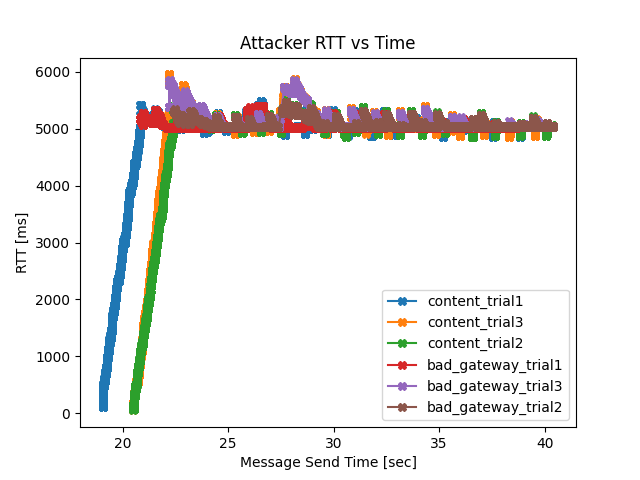

In [61]:
# Plot attacker rtt vs time

%%time

plot_args = {
  "kind": "line",
  "x": "first_send_time_sec",
  "y": "attacker_to_receiver_rtt_ms",
  "marker": "X",
}

coap_codes = attack_dbg_df["coap_code"].unique()
trials = attack_dbg_df["trial"].unique()

ax = None
for coap_code in coap_codes:
    if coap_code is None:
        continue
    for t in trials:
      _df = attack_dbg_df[(attack_dbg_df["coap_code"] == coap_code) & (attack_dbg_df["trial"] == t)]
      label = f"{coap_code}_trial{t}"
      ax = _df.plot(label=label, ax=ax, **plot_args)

ax.set_title("Attacker RTT vs Time")
ax.set_ylabel("RTT [ms]")
ax.set_xlabel("Message Send Time [sec]")
plt.show()

<IPython.core.display.Javascript object>


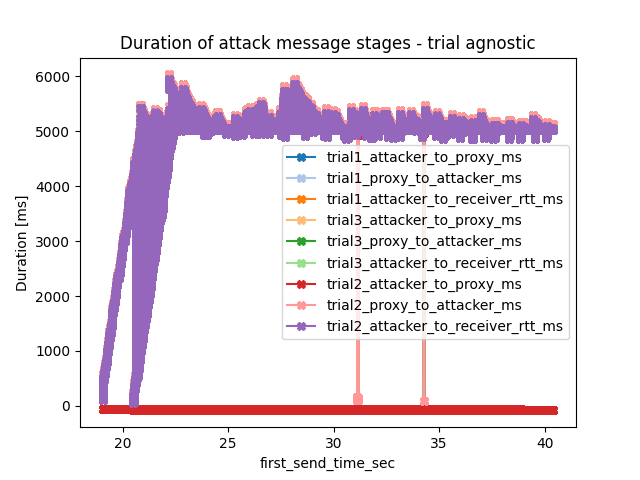

In [62]:
# Plot the duration of different stages of the attack messages

%%time

plot_args = {
  "kind": "line",
  "x": "first_send_time_sec",
  "marker": "X",
}

colors = iter([plt.cm.tab20(i) for i in range(20)])

rtts = ["attacker_to_proxy_ms", "proxy_to_attacker_ms", "attacker_to_receiver_rtt_ms"]

ax = None
for t in trials:
  for rtt in rtts:
    label = f"trial{t}_{rtt}"
    ax = attack_dbg_df.plot(y=rtt, ax=ax, label=label, color=[next(colors)], **plot_args)

ax.set_ylabel("Duration [ms]")
ax.set_title("Duration of attack message stages - trial agnostic")
ax.legend()

plt.show()